<a href="https://colab.research.google.com/github/jadhao/mlflow/blob/master/Comment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/gdrive/
 DataSend2Vikram	    Inter_Ori_955MPa   P0.1MPa
 Figures		    Inter-Pair	       P875MPa
 Inter_angle		    Intra_Ori_0.1MPa   P955MPa
 Inter_dist		    Intra_Ori_100MPa   __pycache__
 Intermolecular_angle.txt   Intra_Ori_400MPa   Shear_rate_orientation_tensor_angle.txt
 Inter_Ori_0.1MPa	    Intra_Ori_636MPa   Shear_rate_stress_viscosity.txt
 Inter_Ori_100MPa	    Intra_Ori_875MPa  'Viscosity (1).gsheet'
 Inter_Ori_400MPa	    Intra_Ori_955MPa   Viscosity.csv
 Inter_Ori_636MPa	    Intra-Pair	       Viscosity.gsheet
 Inter_Ori_875MPa	    LJ_inter.txt


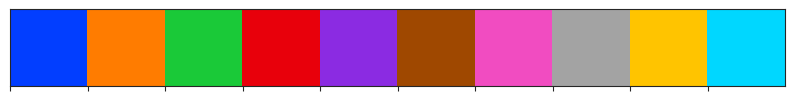

In [ ]:
%reset -f
from google.colab import drive
drive.mount._DEBUG = False
drive.mount('/content/gdrive/')
!ls /content/gdrive/'My Drive'/Shear_flow/data/SQL/T293K
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.font_manager as fm
%matplotlib inline
import seaborn as sns
sns.set_theme(context=None, style='ticks', palette='bright', font='sans-serif', font_scale=1.5, color_codes=True, rc=None)
sns.palplot(sns.color_palette("bright", 10))

from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn import preprocessing
import scipy.linalg as la
from scipy import stats
import re
import pickle
import sys, os, io, string, shutil, math
import glob
sys.path.append('/content/gdrive/My Drive/Shear_flow/data/SQL')
import My_functions_intra as mf

# **Delete Empty Files and Bad Chain Files**  

In [ ]:
root_path="/content/gdrive/My Drive/Shear_flow/data/SQL/T293K/"
file_path=sorted(glob.glob(root_path+'P955MPa/sr*'), key = mf.alphanum_key)               # change pressure value
file_name=sorted(os.listdir(root_path+"P955MPa"), key = mf.alphanum_key)                  # change pressure value
print(file_name)
print(len(file_path))
print(file_path)

# This Block is for removing the files with abnormally large distance between two atoms
for i in range(len(file_path)):
  print("The No. %s Condition is %s: " %(i+1, file_path[i]))
  file_list=sorted(glob.glob(file_path[i]+'/data*'), key = mf.alphanum_key)
  print("The number of frames for this condition is", len(file_list))
  count=0
  if len(file_list)>0:
    for j in range(len(file_list)):
      # remove the empty files
      if os.stat(file_list[j]).st_size == 0:
        os.remove(file_list[j])
        print(file_list[j] + "  is empty")
        continue
      count=0
      org_data = mf.load_data (file_list[j])
      mol_num = org_data.shape[0]
      pair_num = org_data.shape[1]
      for k in range(mol_num):
        if count>0:
          continue
        count=0
        org_data_per_mol=org_data[k,:,:]
        for m in range(pair_num):
          if count>0:
            continue
          count=0
          x_dist = org_data_per_mol[m,5]-org_data_per_mol[m,8]
          y_dist = org_data_per_mol[m,6]-org_data_per_mol[m,9]
          z_dist = org_data_per_mol[m,7]-org_data_per_mol[m,10]
          xx_dist_sqd = x_dist*x_dist
          yy_dist_sqd = y_dist*y_dist
          zz_dist_sqd = z_dist*z_dist
          if xx_dist_sqd>1000 or yy_dist_sqd>1000 or zz_dist_sqd>1000:
            print(file_list[j])
            print("Molecule index is", k+1)
            print("Pair index is", m+1)
            count+=1
            os.remove(file_list[j])

# **Fitting the Viscosity VS Shear Rate (CY)**

<ipython-input-15-13174dbcdba4>:89: RuntimeWarning: divide by zero encountered in log
  error = np.sqrt(np.square(np.log(yita_fit / yita)).mean())*100.0


0.1 MPa 1.8751279324126586 35.9 0.0 599610468.6523514 0.6835374923964712 0.22622834777181483
100 MPa 5.404162071381376 260 0.0 102366576.02055694 0.7338172409419677 0.16532039030766693
200 MPa 4.403621069343072 1429 0.0 34935399.96211262 0.5811984115557618 0.06937874176532827
300 MPa 2.6154669521211695 5670 0.0 5640842.769797758 0.7483014221439326 0.1339162425853312
400 MPa 3.007335110887114 20400 0.0 1648069.7970686138 0.8032180504415176 0.12678308720733528
500 MPa 7.201572232706016 67600 0.0 478850.13735679805 1.0928961836936242 0.13113757682555777
636 MPa 1.2764766359909638 359000.0 0.0 128752.4899487565 0.6258311910028289 0.09243173327500243
796 MPa 3.9486052463989028 2620000.0 0.0 17720.681095056803 0.6487880653070535 0.08929828080624574
875 MPa 1.4014866942499897 5970000.0 0.0 10072.047719176055 0.46125527718772874 0.06809803033746104
955 MPa 0.898230393227453 14000000.0 0.0 3905.855841978687 0.5309985167654818 0.07525908877862775


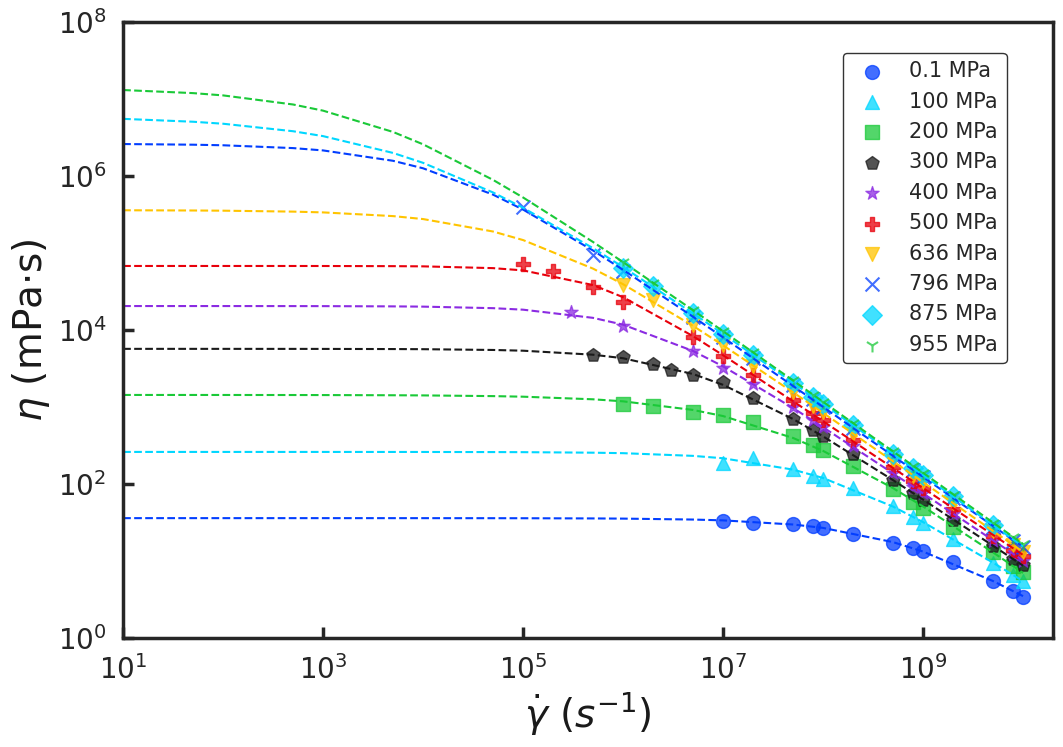

In [ ]:
root_path="/content/gdrive/My Drive/Shear_flow/data/SQL/T293K/"
file_path=root_path+'Viscosity.csv'
save_path="/content/gdrive/My Drive/Shear_flow/data/SQL/T293K/Figures/Fitting/"
df1 = pd.read_csv(file_path)
expt = False
inf_ = False
n_CY = [0.31127412728239, 0.21690919402466, 0.143130678696838, 0.120218984370933, 0.103748777239003, 0.104728903369392, 0.089, 0.08114, 0.075, 0.07528386]
a_CY = [0.838209622732251,0.962519548182223, 0.811951403000027,0.748196582720969,0.59202738702687,0.59230673489252,0.569543, 0.537,0.529656,0.498434]
eta0_CY = [34.0706, 224.6406, 1146.443, 5446.638, 28562.05, 137281.7, 400239.2, 4946051.4, 6081654.8, 19771820.9]
eta_N = [35.9, 260, 1429, 5670, 20400, 67600, 3.59e5, 2.62e6, 5.97e6, 1.4e7]
gamma0_CY = [397529147.09, 89354940.43, 27127413.16, 6463669.28, 1391272.215, 278884.2881, 118858.94, 9802.3, 9022.5, 2691.8]
yita_inf_CY = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
full_rate = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000, 50000000, 100000000, 500000000, 1000000000, 5000000000, 10000000000]
full_rate = np.array(full_rate)
labels = ['0.1 MPa', '100 MPa', '200 MPa', '300 MPa', '400 MPa', '500 MPa', '636 MPa', '796 MPa', '875 MPa', '955 MPa']
markers = ['o', '^', 's', 'p', '*', 'P', 'v', 'x', 'D', '1']
colors = ['b', 'c', 'g', 'k', 'm', 'r', 'y', 'b', 'c', 'g']
font_text = {'family': 'sans-serif', 'color': 'k', 'weight': 'normal', 'fontsize': 24, 'fontstyle': 'normal', 'visible': True}
font_axis = {'family': 'sans-serif', 'color': 'k', 'weight': 'normal', 'fontsize': 28, 'fontstyle': 'normal', 'visible': True}
fig, ax=plt.subplots(figsize=(12,8))
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5, direction='in', pad=12)
ax.tick_params(axis='both', which='minor', labelsize=10, length=5, width=1.5, direction='in', pad=12)
ax.set_xlabel(r'$\dot\gamma$'+' ($s^{-1}$)', fontdict=font_axis)
ax.set_ylabel(r'$\eta$'+' (mPa$\cdot$s)', fontdict=font_axis)
ax.set_xlim(10, 2e10)
ax.set_ylim(1, 1e8)
for i in range(0, df1.shape[1], 3):
  if expt:
    gama = np.array(df1.iloc[:-2, i].dropna())
    yita = np.array(df1.iloc[:-2, i+2].dropna())
  else:
    gama_total = np.array(df1.iloc[:-2, i].dropna())
    yita_total = np.array(df1.iloc[:-2, i+2].dropna())
    indices_MD = np.where(gama_total>=1e5)
    gama = gama_total[indices_MD]
    yita = yita_total[indices_MD]
  idx = (int)(i/3)
  yita_0_opt = eta_N[idx]
  yita_inf_opt = yita_inf_CY[idx]
  gama_0_opt = gamma0_CY[idx]
  n_opt = n_CY[idx]
  a_opt = a_CY[idx]
  yita_fit_opt = yita_inf_opt + (yita_0_opt - yita_inf_opt) * (1 + (gama/gama_0_opt)**a_opt)**((n_opt-1)/a_opt)
  error_min = np.sqrt(np.square(np.log(yita_fit_opt / yita)).mean())*100.0
  for j in range(1000000):
    if i == 0:
      yita_0 = 30.0 + np.random.rand()*10.0
      gama_0 = (4*10**8) + np.random.rand()*(4*10**8)
    elif i == 3:
      yita_0 = 150.0 + np.random.rand()*150.0
      gama_0 = (7*10**7) + np.random.rand()*(5*10**7)
    elif i == 6:
      yita_0 = 900.0 + np.random.rand()*300.0
      gama_0 = (2*10**7) + np.random.rand()*(2*10**7)
    elif i == 9:
      yita_0 = 3500.0 + np.random.rand()*2000.0
      gama_0 = (3*10**6) + np.random.rand()*(5*10**6)
    elif i == 12:
      yita_0 = 15000.0 + np.random.rand()*20000.0
      gama_0 = (10**6) + np.random.rand()*(10**6)
    elif i == 15:
      yita_0 = 90000.0 + np.random.rand()*50000.0
      gama_0 = (3*10**5) + np.random.rand()*(5*10**5)
    elif i == 18:
      yita_0 = 250000.0 + np.random.rand()*300000.0
      gama_0 = (10*10**4) + np.random.rand()*(7*10**4)
    elif i == 21:
      yita_0 = 2*10**6 + np.random.rand()*4*10**6
      gama_0 = (10**4) + np.random.rand()*(10**4)
    elif i == 24:
      yita_0 = 5*10**6 + np.random.rand()*3*10**6
      gama_0 = (5*10**3) + np.random.rand()*(10**4)
    else:
      yita_0 = 1.5*10**7 + np.random.rand()*4*10**7
      gama_0 = 2000 + np.random.rand()*3000
    a = np.random.rand()*2
    n = np.random.rand()*0.5
    yita_0 = eta_N[idx]
    if inf_:
      yita_inf = np.random.rand()*10
    else:
      yita_inf = 0.0

    yita_fit = yita_inf + (yita_0 - yita_inf) * (1 + (gama/gama_0)**(a))**((n-1)/a)
    error = np.sqrt(np.square(np.log(yita_fit / yita)).mean())*100.0
    if error < error_min:
      error_min = error
      yita_0_opt = yita_0
      gama_0_opt = gama_0
      a_opt = a
      n_opt = n
      yita_inf_opt = yita_inf
  print(labels[idx], error_min, yita_0_opt, yita_inf_opt, gama_0_opt, a_opt, n_opt)
  yita_opt = yita_inf_opt + (yita_0_opt - yita_inf_opt) * (1 + (full_rate/gama_0_opt)**(a_opt))**((n_opt-1)/a_opt)
  plt.scatter(gama, yita, marker=markers[(int)(i/3)], s=100,  label=labels[(int)(i/3)], color=colors[(int)(i/3)], alpha=0.75)
  plt.plot(full_rate, yita_opt, linestyle = '--', color=colors[(int)(i/3)])

plt.legend()
plt.legend(bbox_to_anchor=(0.95, 0.95), loc='upper right', fontsize=15, borderaxespad=0,edgecolor='black')
#plt.savefig(save_path+'CY_fitting_expt.png',dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()


# **Fitting the Viscosity VS Shear Rate (Eyring)**

0.1 MPa 17.434169847097976 35.9 0.0 166804018.87913823
100 MPa 15.493814446232621 260 0.0 27776422.117219605
200 MPa 18.150518886901466 1429 0.0 5514627.115128307
300 MPa 12.641376587738657 5670 0.0 1469065.0823269798
400 MPa 6.598299792764757 20400 0.0 437045.0568872428
500 MPa 4.6070747530193605 67600 0.0 138184.29217497515
636 MPa 2.035860373172671 359000.0 0.0 26265.239578231914
796 MPa 3.1055895636420425 2620000.0 0.0 3556.0265681961223
875 MPa 2.2228434113149285 5970000.0 0.0 1563.3280982988754
955 MPa 1.5383734989925548 14000000.0 0.0 668.1865366648192


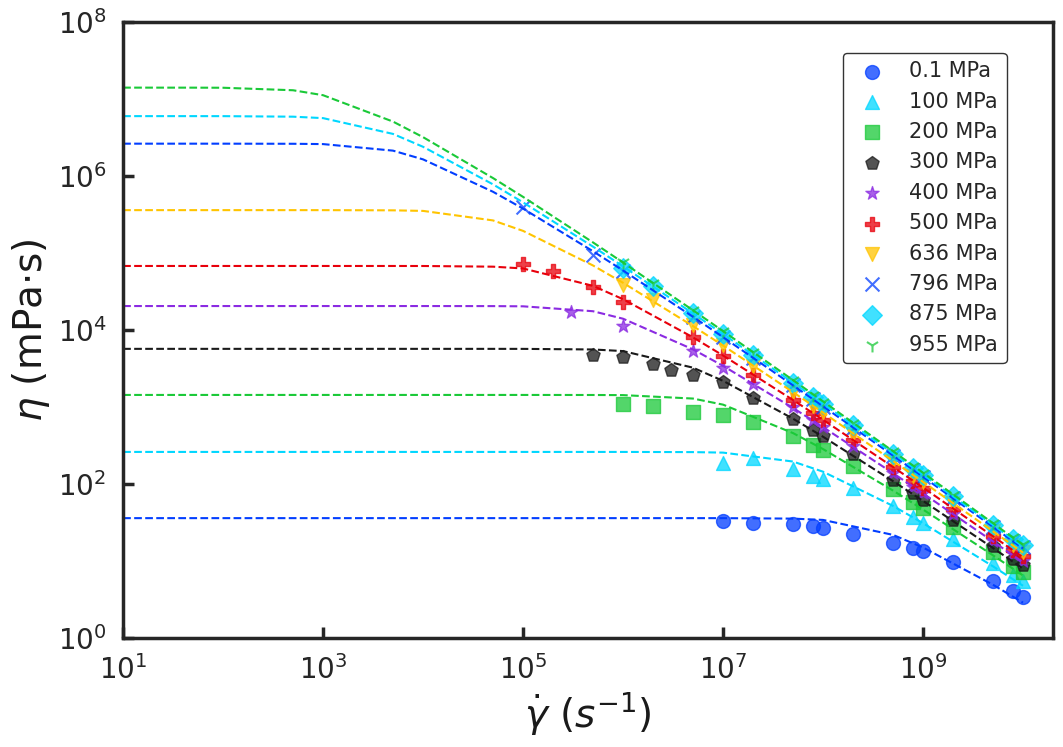

In [ ]:
root_path="/content/gdrive/My Drive/Shear_flow/data/SQL/T293K/"
file_path=root_path+'Viscosity.csv'
save_path="/content/gdrive/My Drive/Shear_flow/data/SQL/T293K/Figures/Fitting/"
df1 = pd.read_csv(file_path)
expt = False         # determining if experimental data are used for fitting
inf_ = False         # determining if eta_infi is used in the model
gamma0_eyring = [244926028.952439, 44352710.6696355,9358399.46469908, 2144603.51785385, 557921.10589804,123787.170036085,30496.7381711333,3971.565,1678.116,704.5]
eta0_eyring = [28.5297327477825,188.925834908758,968.171266948392,4255.4460884515,16712.9050744465,74050.6062828434,314757.352176838,2330864.4,5502778.65,13189380.4]
eta_N = [35.9, 260, 1429, 5670, 20400, 67600, 3.59e5, 2.62e6, 5.97e6, 1.4e7]
yita_inf_eyring = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
full_rate = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000, 50000000, 100000000, 500000000, 1000000000, 5000000000, 10000000000]
full_rate = np.array(full_rate)
labels = ['0.1 MPa', '100 MPa', '200 MPa', '300 MPa', '400 MPa', '500 MPa', '636 MPa', '796 MPa', '875 MPa', '955 MPa']
markers = ['o', '^', 's', 'p', '*', 'P', 'v', 'x', 'D', '1']
colors = ['b', 'c', 'g', 'k', 'm', 'r', 'y', 'b', 'c', 'g']
font_text = {'family': 'sans-serif', 'color': 'k', 'weight': 'normal', 'fontsize': 24, 'fontstyle': 'normal', 'visible': True}
font_axis = {'family': 'sans-serif', 'color': 'k', 'weight': 'normal', 'fontsize': 28, 'fontstyle': 'normal', 'visible': True}
fig, ax=plt.subplots(figsize=(12,8))
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5, direction='in', pad=12)
ax.tick_params(axis='both', which='minor', labelsize=10, length=5, width=1.5, direction='in', pad=12)
ax.set_xlabel(r'$\dot\gamma$'+' ($s^{-1}$)', fontdict=font_axis)
ax.set_ylabel(r'$\eta$'+' (mPa$\cdot$s)', fontdict=font_axis)
ax.set_xlim(10, 2e10)
ax.set_ylim(1, 1e8)
for i in range(0, df1.shape[1], 3):
  if expt:
    gama = np.array(df1.iloc[:, i].dropna())
    yita = np.array(df1.iloc[:, i+2].dropna())
  else:
    gama_total = np.array(df1.iloc[:, i].dropna())
    yita_total = np.array(df1.iloc[:, i+2].dropna())
    indices_MD = np.where(gama_total>=1e5)
    gama = gama_total[indices_MD]
    yita = yita_total[indices_MD]
  idx = (int)(i/3)
  yita_0_opt = eta_N[idx]
  gama_0_opt = gamma0_eyring[idx]
  yita_inf_opt = yita_inf_eyring[idx]
  yita_fit_opt = yita_inf_opt + (yita_0_opt - yita_inf_opt) * gama_0_opt / gama * np.arcsinh(gama/gama_0_opt)
  error_min = np.sqrt(np.square(np.log(yita_fit_opt / yita)).mean())*100.0
  for j in range(1000000):
    if i == 0:
      yita_0 = 25.0 + np.random.rand()*15.0
      gama_0 = (1*10**8) + np.random.rand()*(2*10**8)
    elif i == 3:
      yita_0 = 100.0 + np.random.rand()*150.0
      gama_0 = (1*10**7) + np.random.rand()*(5*10**7)
    elif i == 6:
      yita_0 = 700.0 + np.random.rand()*500.0
      gama_0 = (4*10**6) + np.random.rand()*(5*10**6)
    elif i == 9:
      yita_0 = 3000.0 + np.random.rand()*2000.0
      gama_0 = (10**6) + np.random.rand()*(5*10**6)
    elif i == 12:
      yita_0 = 10000.0 + np.random.rand()*20000.0
      gama_0 = (3*10**5) + np.random.rand()*(5*10**5)
    elif i == 15:
      yita_0 = 60000.0 + np.random.rand()*50000.0
      gama_0 = (7*10**4) + np.random.rand()*(10**5)
    elif i == 18:
      yita_0 = 200000.0 + np.random.rand()*300000.0
      gama_0 = (10**4) + np.random.rand()*(5*10**4)
    elif i == 21:
      yita_0 = 10**6 + np.random.rand()*3*10**6
      gama_0 = (2*10**3) + np.random.rand()*(4*10**3)
    elif i == 24:
      yita_0 = 3*10**6 + np.random.rand()*3*10**6
      gama_0 = (10**3) + np.random.rand()*(5*10**3)
    else:
      yita_0 = 10**7 + np.random.rand()*(10**7)
      gama_0 = 500 + np.random.rand()*1000
    if inf_:
      yita_inf = np.random.rand()*10
    else:
      yita_inf = 0.0
    yita_0 = eta_N[idx]
    yita_fit = yita_inf + (yita_0 - yita_inf) * gama_0 / gama * np.arcsinh(gama/gama_0)
    error = np.sqrt(np.square(np.log(yita_fit / yita)).mean())*100.0
    if error < error_min:
      error_min = error
      yita_0_opt = yita_0
      gama_0_opt = gama_0
      yita_inf_opt = yita_inf
  print(labels[idx], error_min, yita_0_opt, yita_inf_opt, gama_0_opt)
  yita_opt = yita_inf_opt + (yita_0_opt - yita_inf_opt) * gama_0_opt / full_rate * np.arcsinh(full_rate/gama_0_opt)
  plt.scatter(gama, yita, marker=markers[idx], s=100,  label=labels[idx], color=colors[idx], alpha=0.75)
  plt.plot(full_rate, yita_opt, linestyle = '--', color=colors[idx])

plt.legend()
plt.legend(bbox_to_anchor=(0.95, 0.95), loc='upper right', fontsize=15, borderaxespad=0,edgecolor='black')
#plt.savefig(save_path+'Eyring_fitting_expt.png',dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

# **Fitting the Viscosity VS Shear Rate (Carreau)**

0.1 MPa 10.646217870971 35.9 0.0 108463721.91346154 0.5062636475622854
100 MPa 12.803802610364972 260 0.0 34955800.996744394 0.3376910379916624
200 MPa 18.98697269652511 1429 0.0 8989728.31163633 0.26577523811448367
300 MPa 16.068277432626292 5670 0.0 2818258.7577179894 0.22487851893372574
400 MPa 11.897566570951202 20400 0.0 1128545.6220507077 0.17265901797266564
500 MPa 10.141693781641758 67600 0.0 388443.5420520518 0.1544738621845128
636 MPa 5.733662823380648 359000.0 0.0 96503.74915937362 0.11976007280899305
796 MPa 6.572874678870447 2620000.0 0.0 13921.307947175635 0.10925029500682709
875 MPa 3.3984839078772056 5970000.0 0.0 7451.765942953816 0.09172813069588576
955 MPa 1.6710184181492975 14000000.0 0.0 3527.2777084666095 0.08228268535307115


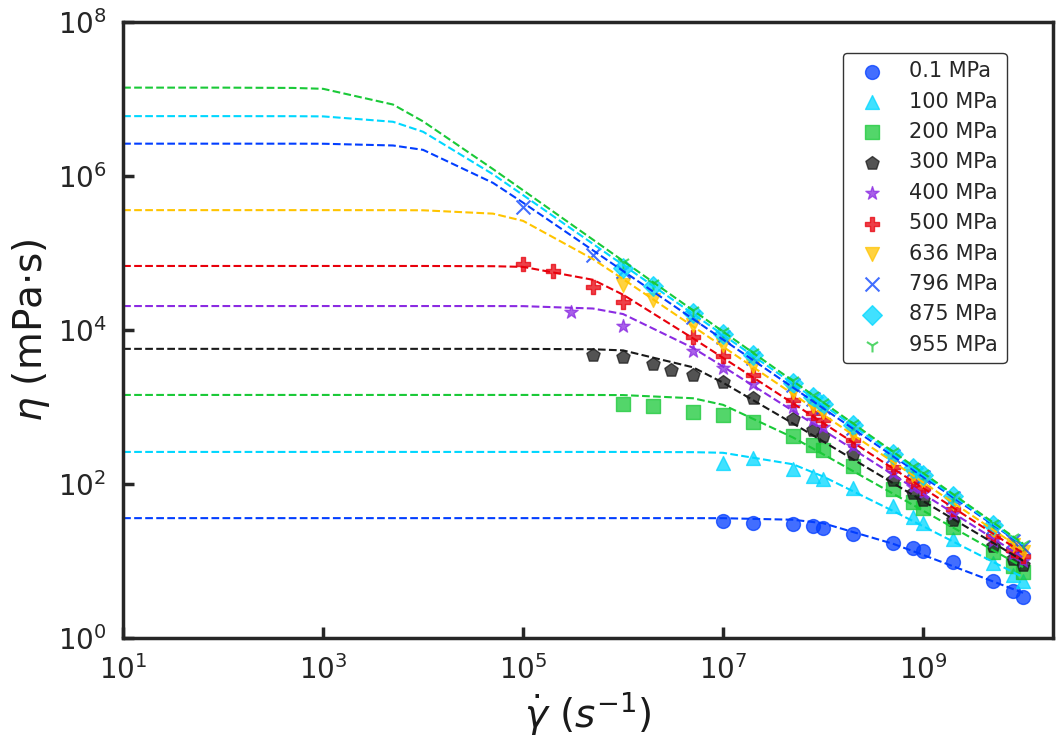

In [ ]:
root_path="/content/gdrive/My Drive/Shear_flow/data/SQL/T293K/"
file_path=root_path+'Viscosity.csv'
save_path="/content/gdrive/My Drive/Shear_flow/data/SQL/T293K/Figures/Fitting/"
df1 = pd.read_csv(file_path)
expt = False
inf_ = False
full_rate = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000, 50000000, 100000000, 500000000, 1000000000, 5000000000, 10000000000]
full_rate = np.array(full_rate)
n_C = [0.447552571745556,0.2967151735986991,0.223633352395156,0.19254864722774423,0.162149235095061,0.1522134987045407,0.103381,0.08582,0.08081,0.07761]
eta0_C = [30.05528, 192.577, 943.0547, 3988.302, 15216.3, 64493.042, 346259.5, 4928711, 6028940.9, 15547667.8]
eta_N = [35.9, 260, 1429, 5670, 20400, 67600, 3.59e5, 2.62e6, 5.97e6, 1.4e7]
gamma0_C = [219101186.04, 69340870, 20529639.33, 5563539.18, 1745910.862, 418295.68, 118597.5, 9204.3, 8399.9, 3354.2]
yita_inf_C = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
labels = ['0.1 MPa', '100 MPa', '200 MPa', '300 MPa', '400 MPa', '500 MPa', '636 MPa', '796 MPa', '875 MPa', '955 MPa']
markers = ['o', '^', 's', 'p', '*', 'P', 'v', 'x', 'D', '1']
colors = ['b', 'c', 'g', 'k', 'm', 'r', 'y', 'b', 'c', 'g']
font_text = {'family': 'sans-serif', 'color': 'k', 'weight': 'normal', 'fontsize': 24, 'fontstyle': 'normal', 'visible': True}
font_axis = {'family': 'sans-serif', 'color': 'k', 'weight': 'normal', 'fontsize': 28, 'fontstyle': 'normal', 'visible': True}
fig, ax=plt.subplots(figsize=(12,8))
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5, direction='in', pad=12)
ax.tick_params(axis='both', which='minor', labelsize=10, length=5, width=1.5, direction='in', pad=12)
ax.set_xlabel(r'$\dot\gamma$'+' ($s^{-1}$)', fontdict=font_axis)
ax.set_ylabel(r'$\eta$'+' (mPa$\cdot$s)', fontdict=font_axis)
ax.set_xlim(10, 2e10)
ax.set_ylim(1, 1e8)
for i in range(0, df1.shape[1], 3):
  if expt:
    gama = np.array(df1.iloc[:-2, i].dropna())
    yita = np.array(df1.iloc[:-2, i+2].dropna())
  else:
    gama_total = np.array(df1.iloc[:-2, i].dropna())
    yita_total = np.array(df1.iloc[:-2, i+2].dropna())
    indices_MD = np.where(gama_total>=1e5)
    gama = gama_total[indices_MD]
    yita = yita_total[indices_MD]

  idx = (int)(i/3)
  yita_0_opt = eta_N[idx]
  gama_0_opt = gamma0_C[idx]
  yita_inf_opt = yita_inf_C[idx]
  n_opt = n_C[idx]

  yita_fit_opt = yita_inf_opt + (yita_0_opt - yita_inf_opt) * (1 + (gama/gama_0_opt)**2)**((n_opt-1)/2.0)
  error_min = np.sqrt(np.square(np.log(yita_fit_opt / yita)).mean())*100.0

  for j in range(1000000):
    if i == 0:
      yita_0 = 25.0 + np.random.rand()*15.0
      gama_0 = (5*10**7) + np.random.rand()*(2*10**8)
    elif i == 3:
      yita_0 = 150.0 + np.random.rand()*150.0
      gama_0 = (2*10**7) + np.random.rand()*(5*10**7)
    elif i == 6:
      yita_0 = 800.0 + np.random.rand()*300.0
      gama_0 = (5*10**6) + np.random.rand()*(10**7)
    elif i == 9:
      yita_0 = 3500.0 + np.random.rand()*2000.0
      gama_0 = (1*10**6) + np.random.rand()*(3*10**6)
    elif i == 12:
      yita_0 = 10000.0 + np.random.rand()*20000.0
      gama_0 = (5*10**5) + np.random.rand()*(10**6)
    elif i == 15:
      yita_0 = 50000.0 + np.random.rand()*50000.0
      gama_0 = (3*10**5) + np.random.rand()*(2*10**5)
    elif i == 18:
      yita_0 = 250000.0 + np.random.rand()*200000.0
      gama_0 = (5*10**4) + np.random.rand()*(7*10**4)
    elif i == 21:
      yita_0 = 2*10**6 + np.random.rand()*4*10**6
      gama_0 = (7*10**3) + np.random.rand()*(10**4)
    elif i == 24:
      yita_0 = 5*10**6 + np.random.rand()*3*10**6
      gama_0 = (3*10**3) + np.random.rand()*(10**4)
    else:
      yita_0 = 1*10**7 + np.random.rand()*(1*10**7)
      gama_0 = 2000 + np.random.rand()*3000
    n = np.random.rand()*0.7
    yita_0 = eta_N[idx]
    if inf_:
      yita_inf = np.random.rand()*10
    else:
      yita_inf = 0.0
    yita_fit = yita_inf + (yita_0 - yita_inf) * (1 + (gama/gama_0)**2)**((n-1)/2.0)
    error = np.sqrt(np.square(np.log(yita_fit / yita)).mean())*100.0
    if error < error_min:
      error_min = error
      yita_0_opt = yita_0
      gama_0_opt = gama_0
      n_opt = n
      yita_inf_opt = yita_inf
  print(labels[idx], error_min, yita_0_opt, yita_inf_opt, gama_0_opt, n_opt)
  yita_opt = yita_inf_opt + (yita_0_opt - yita_inf_opt) * (1 + (full_rate/gama_0_opt)**2)**((n_opt-1)/2.0)
  plt.scatter(gama, yita, marker=markers[idx], s=100,  label=labels[idx], color=colors[idx], alpha=0.75)
  plt.plot(full_rate, yita_opt, linestyle = '--', color=colors[idx])

plt.legend()
plt.legend(bbox_to_anchor=(0.95, 0.95), loc='upper right', fontsize=15, borderaxespad=0,edgecolor='black')
#plt.savefig(save_path+'Carreau_fitting_expt.png',dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

# **Intermediate Scaling Plot**

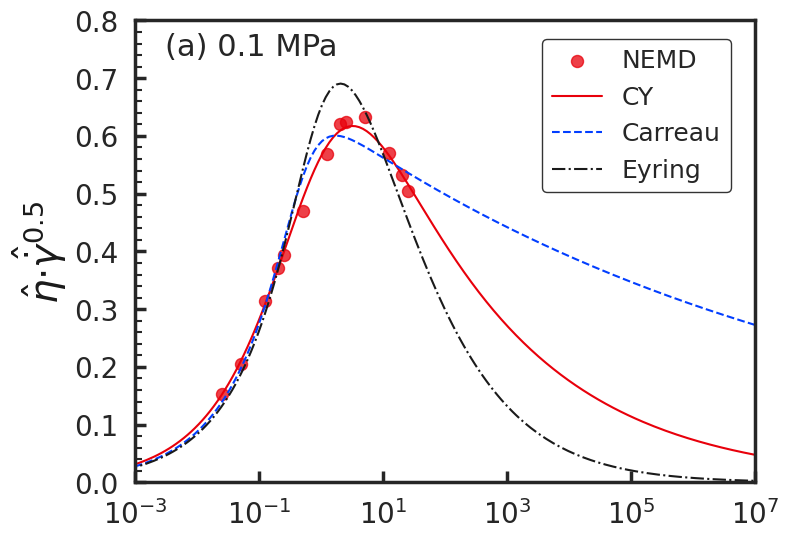

In [ ]:
root_path="/content/gdrive/My Drive/Shear_flow/data/SQL/T293K/"
file_path=root_path+'Viscosity.csv'
save_path="/content/gdrive/My Drive/Shear_flow/data/SQL/T293K/Figures/Fitting/"
df1 = pd.read_csv(file_path)
n_CY = [0.311274, 0.20137, 0.143131, 0.13083, 0.103749, 0.104729, 0.088248, 0.086249, 0.070763, 0.075254]
a_CY = [0.83821,0.89519, 0.811951,0.76138,0.592027,0.592307,0.543943, 0.527994,0.465324,0.47674]
eta0_CY = [34.0706, 230.897, 1146.443, 5431.34, 28562.05, 137281.7, 575115.5, 5529876, 5572353, 34430652]
gamma0_CY = [397529147.09, 93090311.4, 27127413.16, 6082628.56, 1391272.215, 278884.2881, 80792.65499, 8168.293335, 10590.91613, 1473.382773]
n_C = [0.447553,0.296715,0.223633,0.192549,0.162149,0.152213,0.120476,0.109143,0.090615,0.082331]
eta0_C = [30.05528, 191.5769, 943.0547, 3988.302, 15216.3, 64493.04, 346550.1, 2619614, 5957415, 36115368]
gamma0_C = [219101186.04, 69340870.12, 20529639.33, 5563539.179, 1745910.862, 418295.6845, 99994.72358, 13927.93684, 7542.203565, 1255.856481]
gamma0_eyring = [244635041.44, 44352710.67,9358399.465, 2146145, 561020.8,123787.17,30496.73817,3682.092995,2296.644698,737.6364985]
eta0_eyring = [28.54,188.9258,968.1713,4255.69,16632.67,74050.61,314757.4,2539457,4203673,12785344]
lower_bound = [18,10,14,4,4,4,4,3,3,0]
upper_bound = [52,50,50,50,50,50,50,50,50,50]

font_text = {'family': 'sans-serif', 'color': 'k', 'weight': 'normal', 'fontsize': 24, 'fontstyle': 'normal', 'visible': True}
font_axis = {'family': 'sans-serif', 'color': 'k', 'weight': 'normal', 'fontsize': 28, 'fontstyle': 'normal', 'visible': True}
fig, ax=plt.subplots(figsize=(8,6))
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2.5)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5, direction='in', pad=12)
ax.tick_params(axis='both', which='minor', labelsize=10, length=5, width=1.5, direction='in', pad=12)
for i in range(0, 3, 3):

  gamma = np.array(df1.iloc[:, i].dropna())
  eta = np.array(df1.iloc[:, i+2].dropna())

  indices_MD = np.where(gamma>=1e5)
  indices_expt = np.where(gamma<1e5)
  gamma_MD = gamma[indices_MD]
  gamma_expt = gamma[indices_expt]
  eta_MD = eta[indices_MD]
  eta_expt = eta[indices_expt]
  idx = (int)(i/3)
  full_range = np.arange(lower_bound[idx],upper_bound[idx],0.2)
  full_rate = 2**full_range
  eta_0_CY = eta0_CY[idx]
  eta_0_Eyring = eta0_eyring[idx]
  eta_0_Carreau = eta0_C[idx]
  gamma_0_CY = gamma0_CY[idx]
  gamma_0_Eyring = gamma0_eyring[idx]
  gamma_0_Carreau = gamma0_C[idx]
  a_C_Y = a_CY[idx]
  n_C_Y = n_CY[idx]
  n_Carreau = n_C[idx]

  gamma_hat_MD = gamma_MD/gamma_0_CY
  eta_hat_MD = eta_MD/eta_0_CY*np.sqrt(gamma_hat_MD)

  gamma_hat_expt = gamma_expt/gamma_0_CY
  eta_hat_expt = eta_expt/eta_0_CY*np.sqrt(gamma_hat_expt)

  gamma_hat_CY = full_rate/gamma_0_CY
  eta_CY = eta_0_CY * (1+(full_rate/gamma_0_CY)**a_C_Y)**((n_C_Y-1)/a_C_Y)
  eta_hat_CY = eta_CY/eta_0_CY*np.sqrt(gamma_hat_CY)

  eta_Eyring = eta_0_Eyring*gamma_0_Eyring/full_rate*np.arcsinh(full_rate/gamma_0_Eyring)
  eta_hat_Eyring = eta_Eyring/eta_0_CY*np.sqrt(gamma_hat_CY)

  eta_Carreau = eta_0_Carreau*(1+(full_rate/gamma_0_Carreau)**2.0)**((n_Carreau-1)/2.0)
  eta_hat_Carreau = eta_Carreau/eta_0_CY*np.sqrt(gamma_hat_CY)

  plt.scatter(gamma_hat_MD, eta_hat_MD, marker='o', s=75, label = 'NEMD', color='r', alpha=0.75)
  #plt.scatter(gamma_hat_expt, eta_hat_expt, marker='o', s=75, label = 'Expt.', color='g', alpha=0.75)
  plt.plot(gamma_hat_CY, eta_hat_CY, linestyle = '-', color='r', label = 'CY')
  plt.plot(gamma_hat_CY, eta_hat_Carreau, linestyle = '--', color='b', label = 'Carreau')
  plt.plot(gamma_hat_CY, eta_hat_Eyring, linestyle = '-.', color='k', label = 'Eyring')


plt.text(3e-3, 0.74, '(a) 0.1 MPa', fontsize = 22)
plt.legend()
plt.legend(bbox_to_anchor=(0.96, 0.96), loc='upper right', fontsize=18, borderaxespad=0,edgecolor='black')
ax.set_xlim(1e-3, 1e7)
ax.set_ylim(0, 0.8)
#ax.set_xlabel(r'$\hat\dot\gamma$', fontdict=font_axis)
ax.set_ylabel(r'$\hat\eta$'+'$\cdot\hat\dot\gamma^{0.5}$', fontdict=font_axis)
plt.savefig(save_path+'Muser_0.1.png',dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

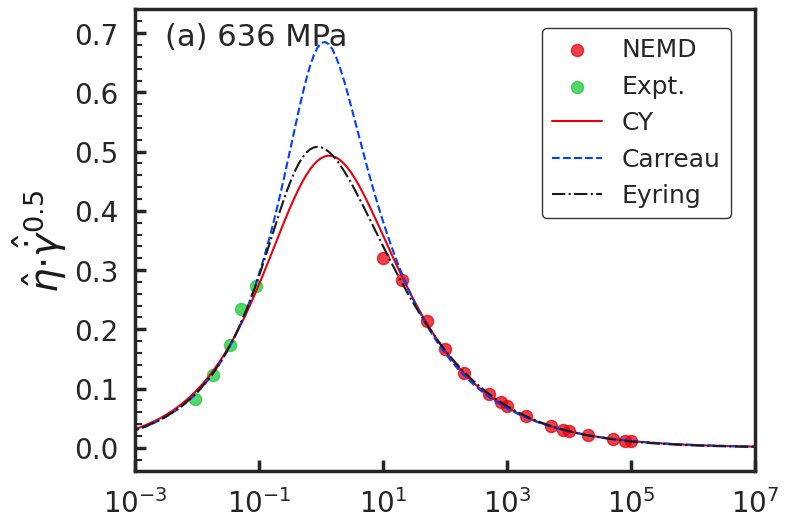

In [ ]:
root_path="/content/gdrive/My Drive/Shear_flow/data/SQL/T293K/"
file_path=root_path+'Viscosity.csv'
save_path="/content/gdrive/My Drive/Shear_flow/data/SQL/T293K/Figures/Fitting/"
df1 = pd.read_csv(file_path)
n_CY = [0.110766, 0.086249, 0.083595, 0.080558]
a_CY = [0.862037, 0.586326, 0.652326, 0.626491]
eta0_CY = [381430.36, 3265016.76, 6865154, 17208014]
gamma0_CY = [99792.71, 14460.55, 6968.1, 2904.82]
n_C = [0.11953, 0.12222, 0.1104, 0.0904]
eta0_C = [357274.39, 2086353.99, 5016039.389, 11606780.57]
gamma0_C = [97529.59, 15552.49, 7186.29, 3904.9]
gamma0_eyring = [26182.84, 3971.565, 1678.116, 704.5]
eta0_eyring = [359993.44, 2330864.4, 5502778.65, 13189380.4]
lower_bound = [0,0,0,0]
upper_bound = [40,40,40,40]

font_text = {'family': 'sans-serif', 'color': 'k', 'weight': 'normal', 'fontsize': 24, 'fontstyle': 'normal', 'visible': True}
font_axis = {'family': 'sans-serif', 'color': 'k', 'weight': 'normal', 'fontsize': 28, 'fontstyle': 'normal', 'visible': True}
fig, ax=plt.subplots(figsize=(8,6))
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2.5)
ax.set_xscale('log')
#ax.set_yscale('log')
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5, direction='in', pad=12)
ax.tick_params(axis='both', which='minor', labelsize=10, length=5, width=1.5, direction='in', pad=12)

for i in range(18, 21, 3):

  gamma = np.array(df1.iloc[:, i].dropna())
  eta = np.array(df1.iloc[:, i+2].dropna())

  indices_MD = np.where(gamma>=1e5)
  indices_expt = np.where(gamma<1e5)
  gamma_MD = gamma[indices_MD]
  gamma_expt = gamma[indices_expt]
  eta_MD = eta[indices_MD]
  eta_expt = eta[indices_expt]
  idx = (int)((i-18)/3)
  full_range = np.arange(lower_bound[idx],upper_bound[idx],0.2)
  full_rate = 2**full_range
  eta_0_CY = eta0_CY[idx]
  eta_0_Eyring = eta0_eyring[idx]
  eta_0_Carreau = eta0_C[idx]
  gamma_0_CY = gamma0_CY[idx]
  gamma_0_Eyring = gamma0_eyring[idx]
  gamma_0_Carreau = gamma0_C[idx]
  a_C_Y = a_CY[idx]
  n_C_Y = n_CY[idx]
  n_Carreau = n_C[idx]

  gamma_hat_MD = gamma_MD/gamma_0_CY
  eta_hat_MD = eta_MD/eta_0_CY*np.sqrt(gamma_hat_MD)

  gamma_hat_expt = gamma_expt/gamma_0_CY
  eta_hat_expt = eta_expt/eta_0_CY*np.sqrt(gamma_hat_expt)

  gamma_hat_CY = full_rate/gamma_0_CY
  eta_CY = eta_0_CY * (1+(full_rate/gamma_0_CY)**a_C_Y)**((n_C_Y-1)/a_C_Y)
  eta_hat_CY = eta_CY/eta_0_CY*np.sqrt(gamma_hat_CY)

  eta_Eyring = eta_0_Eyring*gamma_0_Eyring/full_rate*np.arcsinh(full_rate/gamma_0_Eyring)
  eta_hat_Eyring = eta_Eyring/eta_0_CY*np.sqrt(gamma_hat_CY)

  eta_Carreau = eta_0_Carreau*(1+(full_rate/gamma_0_Carreau)**2.0)**((n_Carreau-1)/2.0)
  eta_hat_Carreau = eta_Carreau/eta_0_CY*np.sqrt(gamma_hat_CY)

  plt.scatter(gamma_hat_MD, eta_hat_MD, marker='o', s=75, label = 'NEMD', color='r', alpha=0.75)
  plt.scatter(gamma_hat_expt, eta_hat_expt, marker='o', s=75, label = 'Expt.', color='g', alpha=0.75)
  plt.plot(gamma_hat_CY, eta_hat_CY, linestyle = '-', color='r', label = 'CY')
  plt.plot(gamma_hat_CY, eta_hat_Carreau, linestyle = '--', color='b', label = 'Carreau')
  plt.plot(gamma_hat_CY, eta_hat_Eyring, linestyle = '-.', color='k', label = 'Eyring')

plt.text(3e-3, 0.68, '(a) 636 MPa', fontsize = 22)
plt.legend()
plt.legend(bbox_to_anchor=(0.96, 0.96), loc='upper right', fontsize=18, borderaxespad=0,edgecolor='black')
ax.set_xlim(1e-3, 1e7)
ax.set_ylim(-0.04, 0.74)
#ax.set_xlabel(r'$\hat\dot\gamma$', fontdict=font_axis)
ax.set_ylabel(r'$\hat\eta$'+'$\cdot\hat\dot\gamma^{0.5}$', fontdict=font_axis)
plt.savefig(save_path+'Muser_636_expt.png',dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

# **Dividing Lines**

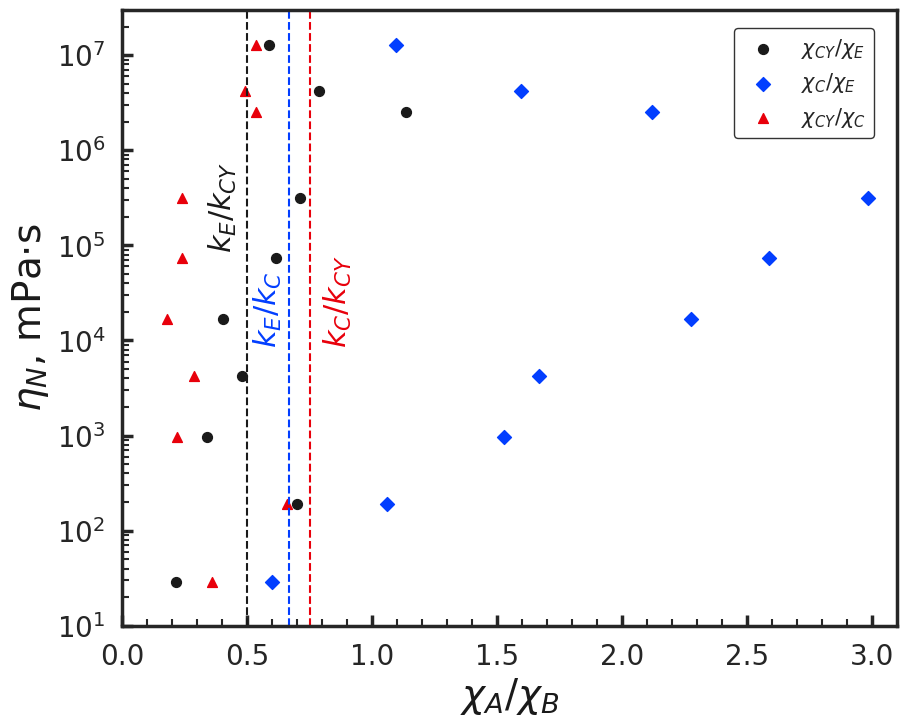

In [ ]:
save_path="/content/gdrive/My Drive/Shear_flow/data/SQL/T293K/Figures/Fitting/"
x_CY = np.array([2.146,	5.196,	1.667,	2.732,	1.529,	2.393,	1.368,	3.520,	1.595,	0.897])
x_C = np.array([5.959,	7.858,	7.535,	9.487,	8.582,	10.061,	5.732,	6.574,	3.235,	1.672])
x_E = np.array([9.935,	7.414,	4.931,	5.687,	3.773,	3.888,	1.920,	3.101,	2.030,	1.526])
y = [28.54,	188.926,	968.171,	4255.690,	16712.91,	74050.61,	314757.4,	2539457,	4203673,	12785344]
font_text = {'family': 'sans-serif', 'color': 'k', 'weight': 'normal', 'fontsize': 24, 'fontstyle': 'normal', 'visible': True}
font_axis = {'family': 'sans-serif', 'color': 'k', 'weight': 'normal', 'fontsize': 28, 'fontstyle': 'normal', 'visible': True}
fig, ax=plt.subplots(figsize=(10,8))
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2.5)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5, direction='in', pad=12)
ax.tick_params(axis='both', which='minor', labelsize=10, length=5, width=1.5, direction='in', pad=12)
ax.set_ylabel(r'$\eta_{N}$, mPa$\cdot$s', fontdict=font_axis)
ax.set_xlabel(r'$\chi_A/\chi_B$', fontdict=font_axis)
plt.scatter(x_CY/x_E, y, marker='o', color='k', s=50, label = r'$\chi_{CY}/\chi_{E}$')
plt.scatter(x_C/x_E, y, marker='D',color='b', s=50,label = r'$\chi_{C}/\chi_{E}$')
plt.scatter(x_CY/x_C, y, marker='^', color='r', s=50,label = r'$\chi_{CY}/\chi_{C}$')
plt.plot([0.5,0.5], [10,3e7], linestyle = '--', color='k')
plt.plot([2/3,2/3], [10,3e7], linestyle = '--', color='b')
plt.plot([0.75,0.75], [10,3e7], linestyle = '--', color='r')
plt.text(0.34, 1e5, r'$k_{E}/k_{CY}$', c='k', rotation = 'vertical', fontsize = 22)
plt.text(0.52, 1e4, r'$k_{E}/k_{C}$', c='b', rotation = 'vertical', fontsize = 22)
plt.text(0.8, 1e4, r'$k_{C}/k_{CY}$', c='r', rotation = 'vertical', fontsize = 22)
plt.legend()
plt.legend(bbox_to_anchor=(0.97, 0.97), loc='upper right', fontsize=15, borderaxespad=0,edgecolor='black')
ax.set_xlim(0, 3.1)
ax.set_ylim(10, 3e7)
plt.savefig(save_path+'dividing.png',dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

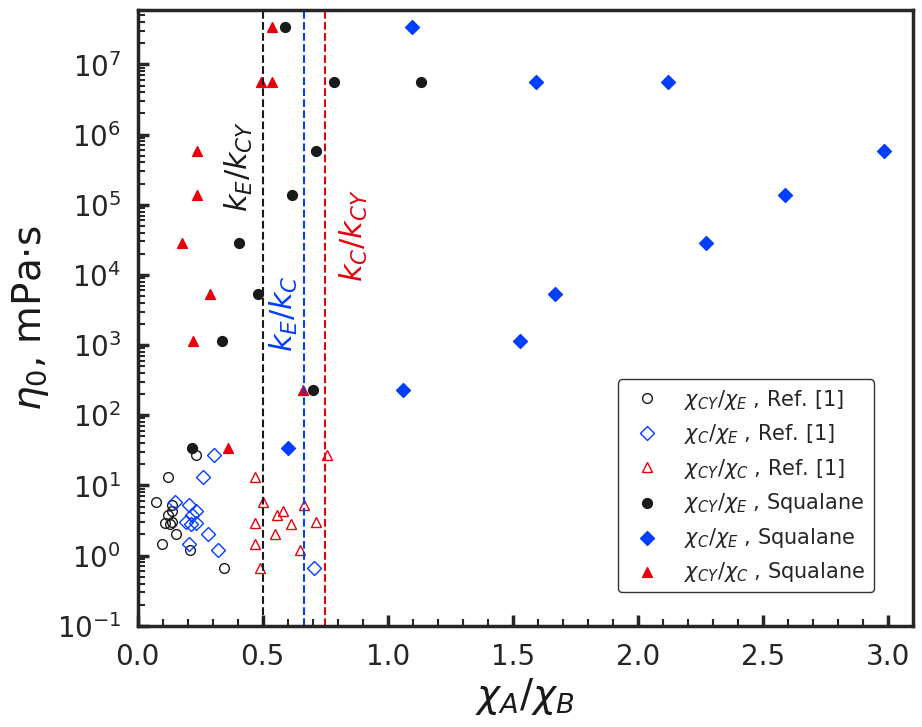

In [ ]:
save_path="/content/gdrive/My Drive/Shear_flow/data/SQL/T293K/Figures/Fitting/"
x_CY_1 = np.array([4.12,	1.93,	1.86,	1.25, 1.65, 0.97, 1.61, 1.67, 1.74, 1.84, 1.07, 1.77, 1.97])
x_C_1 = np.array([5.45, 4.11, 2.79, 2.67, 3.00, 2.06, 3.29, 2.58, 2.44, 3.16, 2.14,  2.88, 3.53])
x_E_1 = np.array([17.77, 15.78, 13.73, 11.53, 10.64, 9.96, 4.66, 8.03, 12.63, 13.47, 14.46, 13.62, 16.26])
y_1 = [26.76, 13.25, 5.24, 2.96, 2.00, 1.46, 0.66, 1.20, 2.97, 4.36, 5.90, 2.81, 3.83]
x_CY_2 = np.array([2.146,	5.196,	1.667,	2.732,	1.529,	2.393,	1.368,	3.520,	1.595,	0.897])
x_C_2 = np.array([5.959,	7.858,	7.535,	9.487,	8.582,	10.061,	5.732,	6.574,	3.235,	1.672])
x_E_2 = np.array([9.935,	7.414,	4.931,	5.687,	3.773,	3.888,	1.920,	3.101,	2.030,	1.526])
#y_2 = [28.54,	188.9258,	968.1713,	4255.446,	16712.91,	74050.61,	314757.4,	2539457,	4203673,	12785344]
y_2 = [34.071,	230.897,	1146.443,	5431.34,	28560,	137300,	575100,	5530000,	5572000,	34430000]

font_text = {'family': 'sans-serif', 'color': 'k', 'weight': 'normal', 'fontsize': 24, 'fontstyle': 'normal', 'visible': True}
font_axis = {'family': 'sans-serif', 'color': 'k', 'weight': 'normal', 'fontsize': 28, 'fontstyle': 'normal', 'visible': True}
fig, ax=plt.subplots(figsize=(10,8))
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2.5)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, length=8, width=2.5, direction='in', pad=12)
ax.tick_params(axis='both', which='minor', labelsize=10, length=5, width=1.5, direction='in', pad=12)
ax.set_ylabel(r'$\eta_{0}$, mPa$\cdot$s', fontdict=font_axis)
ax.set_xlabel(r'$\chi_A/\chi_B$', fontdict=font_axis)

plt.plot(x_CY_1/x_E_1, y_1, 'ko', markerfacecolor='none', ms=7, label=r'$\chi_{CY}/\chi_{E}$' + " , Ref. [1]", markeredgecolor='k')
plt.plot(x_C_1/x_E_1, y_1, 'bD', markerfacecolor='none', ms=7, label=r'$\chi_{C}/\chi_{E}$' + " , Ref. [1]", markeredgecolor='b')
plt.plot(x_CY_1/x_C_1, y_1, 'r^', markerfacecolor='none', ms=7, label=r'$\chi_{CY}/\chi_{C}$' + " , Ref. [1]", markeredgecolor='r')

plt.scatter(x_CY_2/x_E_2, y_2, marker='o', color='k', s=50, label = r'$\chi_{CY}/\chi_{E}$' + " , Squalane")
plt.scatter(x_C_2/x_E_2, y_2, marker='D',color='b', s=50,label = r'$\chi_{C}/\chi_{E}$' + " , Squalane")
plt.scatter(x_CY_2/x_C_2, y_2, marker='^', color='r', s=50,label = r'$\chi_{CY}/\chi_{C}$' + " , Squalane")

plt.plot([0.5,0.5], [0.1,1e8], linestyle = '--', color='k')
plt.plot([2/3,2/3], [0.1,1e8], linestyle = '--', color='b')
plt.plot([0.75,0.75], [0.1,1e8], linestyle = '--', color='r')
#plt.plot([0,1.0], [28,28], linestyle = '--', color='g')
plt.text(0.34, 1e5, r'$k_{E}/k_{CY}$', c='k', rotation = 'vertical', fontsize = 22)
plt.text(0.52, 1e3, r'$k_{E}/k_{C}$', c='b', rotation = 'vertical', fontsize = 22)
plt.text(0.8, 1e4, r'$k_{C}/k_{CY}$', c='r', rotation = 'vertical', fontsize = 22)
#plt.text(0.8, 1e2, 'Our data', c='g', rotation = 'horizontal', fontsize = 16)
#plt.text(0.76, 4, 'Gao-Muser data', c='g', rotation = 'horizontal', fontsize = 16)
plt.legend()
plt.legend(bbox_to_anchor=(0.95, 0.4), loc='upper right', fontsize=15, borderaxespad=0,edgecolor='black')
ax.set_xlim(0, 3.1)
ax.set_ylim(0.1, 6e7)
plt.savefig(save_path+'dividing_CY.png',dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()